In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
import os

In [2]:
#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [3]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
#DATA_PATH = "~chandlermccann/Downloads/"
DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [26]:
df= pd.read_csv(INPUT_FILE, encoding='latin-1')
df.drop(['Row ID'], axis=1, inplace=True)
df.head()

/Users/chandlermccann/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,country_name,water_source,water_tech,status_id,management,pay,installer,install_year,status,source,adm1,adm2,wpdx_id,report_date,country_id,activity_id,data_lnk,orig_lnk,photo_lnk,converted,created,updated,lat_deg,lon_deg,Location,Count,fecal_coliform_presence,fecal_coliform_value,subjective_quality,new_report_date,new_install_year,age_well,age_well_days,status_binary,age_well_years
0,"Tanzania, United Republic of",Spring,Gravity Communal standpipe,no,__MISSING__,Never pay,RWE,1972.0,Status:Not functional|Quantity:Dry|Quality:Soft,SNV,Arusha,Longido,wpdx-00000001,01/05/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.83257,36.3090,"(-2.83257, 36.309)",1,NaN,NaN,NaN,2008-01-05,1972-01-01 00:00:00,13153 days 00:00:00.000000000,13153,1,36.0
1,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Breakdown Year:2007|Reason N...,SNV,Arusha,Longido,wpdx-00000002,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84781,36.5284,"(-2.84781, 36.5284)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3.0
2,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000003,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.84796,36.5288,"(-2.84796, 36.5288)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3.0
3,"Tanzania, United Republic of",Rainwater harvesting,Gravity Communal standpipe,yes,__MISSING__,Never pay,World Vision,2005.0,Status:Functional|Quantity:Seasonal|Quality:Soft,SNV,Arusha,Longido,wpdx-00000004,01/01/2008 12:00:00 AM +0000,TZ,__MISSING__,http://www.dropbox.com/s/50779gal9v4z4y6/TZ%20...,__MISSING__,__MISSING__,"""#water_tech, #country_id, #data_lnk""",10/23/2015 01:03:07 AM +0000,10/23/2015 01:03:07 AM +0000,-2.85318,36.5276,"(-2.85318, 36.5276)",1,NaN,NaN,NaN,2008-01-01,2005-01-01 00:00:00,1095 days 00:00:00.000000000,1095,0,3.0
4,Nicaragua,__MISSING__,__MISSING__,yes,__MISSING__,__MISSING__,__MISSING__,2011.0,__MISSING__,El Porvenier,Matagalpa,Terrabona,wpdx-00000005,01/01/2011 12:00:00 AM +0000,NI,__MISSING__,http://www.dropbox.com/s/0f70mln5roxhy29/ProjT...,https://www.waterpointdata.org/dataset/resourc...,__MISSING__,"#data_lnk, #lon_deg, #lat_deg, #country_id",04/08/2016 08:35:49 AM +0000,04/08/2016 08:35:49 AM +0000,12.74070,-86.0121,"(12.7407, -86.0121)",1,NaN,NaN,NaN,2011-01-01,2011-01-01 00:00:00,0 days 00:00:00.000000000,0,0,0.0


In [74]:
def predict_df(df):
    """args: Pandas Dataframe
       1) label encodes all variables, and stores the inverse transforms in a dictionary
       2) Does stratified train/test split on each country
       3) Uses Grid Search on training data
       4) Takes parameters from best model, calculates AUC/ Accuracy
       returns:
       1) Dictionary of label encoded variables and their inverse (I hope)
       2) XGBoost model object with the best model"""
    df2 = df.copy()
    
    #only keep prediction columns
    pred_cols = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years', 'status_binary']

    df2=df2[pred_cols]

    #convert all fields to int labels for the classifier
    lb=LabelEncoder() #instantiate label encoder

    #create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
    from collections import defaultdict
    d = defaultdict(LabelEncoder)

    # Encoding each variable
    fit = df2.apply(lambda x: d[x.name].fit_transform(x))

    # Inverse the encoded
    inverse = fit.apply(lambda x: d[x.name].inverse_transform(x))
    
    #define features and target columns
    X = fit[fit.columns[:-1]] 
    Y= fit.status_binary
    
    #Create 20% test sets, 80% training, stratifying on Y.
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,  test_size=.2, random_state=7, stratify=Y)
    
    #use stratified K folds and gridsearch..ON THE TRAINING DATA
    params = {'learning_rate':[0.05,.1], 'max_depth':[3,4], 'n_estimators':[200,300],}
    model2 = model_selection.GridSearchCV(XGBClassifier(scoring='logloss'), params)
    model2.fit(X_train, y_train )
    print('model fit for ', df.country_name.unique())
    print(model2.best_params_)
    #print(model2.grid_scores_)
    print(model2.best_score_)
    
    
    #get auc. need to reshape
    preds2 = model2.predict_proba(X_test)[:,1]
    preds2a = model2.predict(X_test)
    #pd.DataFrame(preds2).describe()
    print("Accuracy : %.4g"%metrics.accuracy_score(y_test, preds2a))
    print("AUC Score (Test): %f"%metrics.roc_auc_score(y_test, preds2))
    
    # calculate the fpr and tpr for all thresholds of the classification
    #probs = model.predict_proba(X_test)
    #preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds2)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    
    plt.title('ROC Curve - GradBoosted Trees')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    #retrain with best params for feature importances
    best_model = XGBClassifier(params= model2.best_params_)
    #refit
    best_model.fit(X_train, y_train)
    #plot feature importance
    #%matplotlib inline
    #xgb.plot_importance(best_model)
    
    return best_model, d
    #plt.savefig('ROC_Swaziland.png')

In [37]:
#create a dictionary to store all of the dataframes in for each country level model with the country name as the key
df_dict = {}
for name in df.country_name.unique():
    #print(name)
    df_dict[name] = df[df.country_name== name]

In [73]:
for k in countries_for_preds:
    print(k,df_dict[k].shape)

Afghanistan (59849, 35)
Sierra Leone (54864, 35)
Zimbabwe (38777, 35)
Tanzania, United Republic of (23462, 35)
Kenya (21207, 35)
Liberia (14053, 35)
Malawi (12260, 35)
South Sudan (6088, 35)
Uganda (113667, 35)
India (5887, 35)


model fit for  ['Afghanistan']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.7906806742
Accuracy : 0.7923
AUC Score (Test): 0.830980


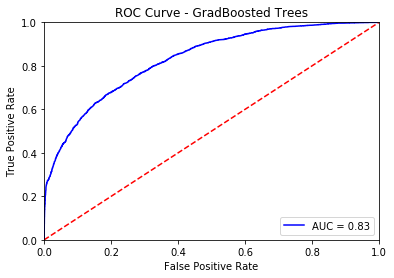

TypeError: 'NoneType' object is not iterable

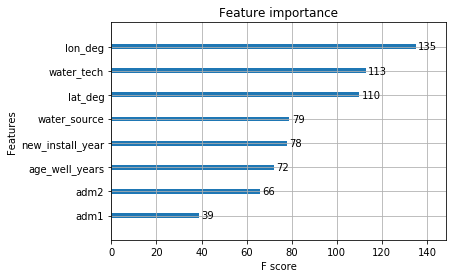

In [50]:
model_afg, dict_afg = predict_df(df_dict['Afghanistan'])


model fit for  ['Zimbabwe']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.753554044035
Accuracy : 0.7603
AUC Score (Test): 0.816819


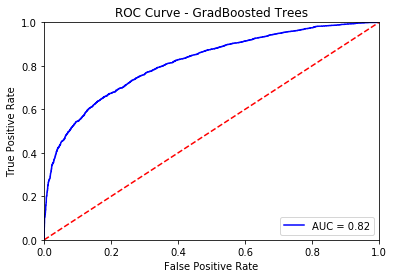

In [56]:
model_zimbabwe, dict_zimbabwe = predict_df(df_dict['Zimbabwe'])


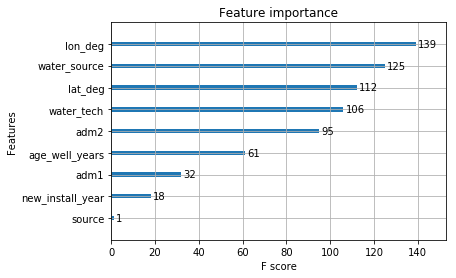

In [57]:
xgb.plot_importance(model_zimbabwe)

model fit for  ['Sierra Leone']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.935271467955
Accuracy : 0.9314
AUC Score (Test): 0.965785


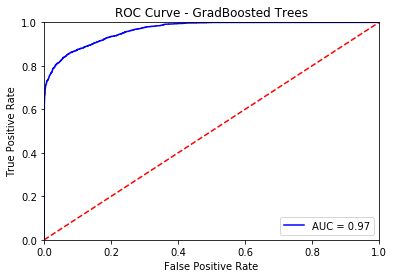

In [58]:
model_sl, dict_sl = predict_df(df_dict['Sierra Leone'])

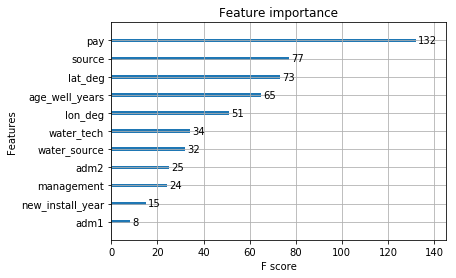

In [65]:
xgb.plot_importance(model_sl)

model fit for  ['Kenya']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.872679045093
Accuracy : 0.8777
AUC Score (Test): 0.842388


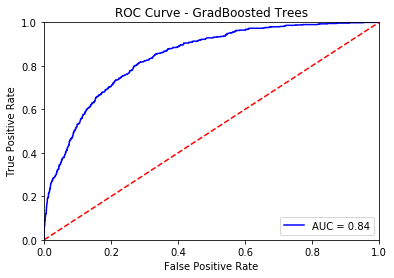

In [59]:
model_kenya, dict_kenya = predict_df(df_dict['Kenya'])

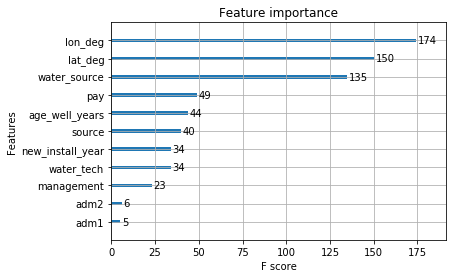

In [66]:
xgb.plot_importance(model_kenya)

model fit for  ['Liberia']
{'max_depth': 4, 'n_estimators': 200, 'learning_rate': 0.1}
0.822362568938
Accuracy : 0.815
AUC Score (Test): 0.812926


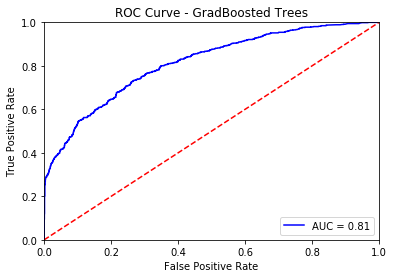

In [60]:
model_liberia, dict_liberia = predict_df(df_dict['Liberia'])

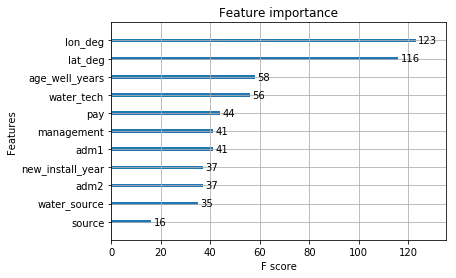

In [67]:
xgb.plot_importance(model_liberia)

model fit for  ['Malawi']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.826264274062
Accuracy : 0.8238
AUC Score (Test): 0.836717


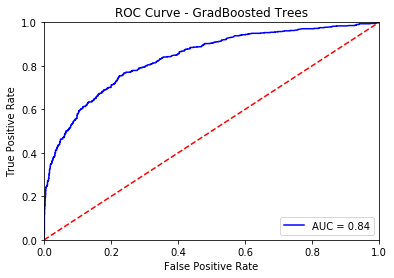

In [61]:
model_malawi, dict_malawi = predict_df(df_dict['Malawi'])

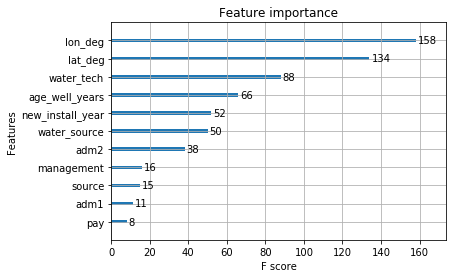

In [68]:
xgb.plot_importance(model_malawi)

model fit for  ['South Sudan']
{'max_depth': 4, 'n_estimators': 200, 'learning_rate': 0.05}
0.804106776181
Accuracy : 0.8112
AUC Score (Test): 0.764214


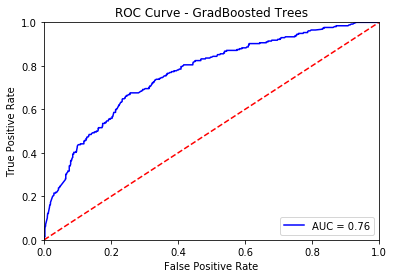

In [62]:
model_sudan, dict_sudan = predict_df(df_dict['South Sudan'])


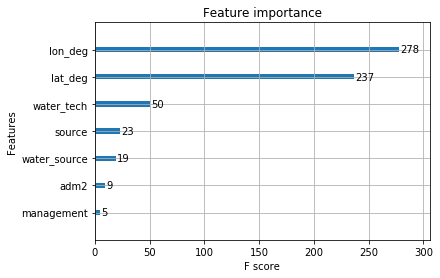

In [69]:
xgb.plot_importance(model_sudan)

model fit for  ['Uganda']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.833646750905
Accuracy : 0.8335
AUC Score (Test): 0.827183


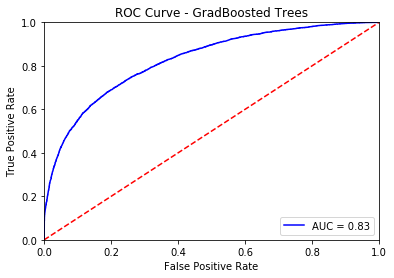

In [63]:
model_uganda, dict_uganda = predict_df(df_dict['Uganda'])


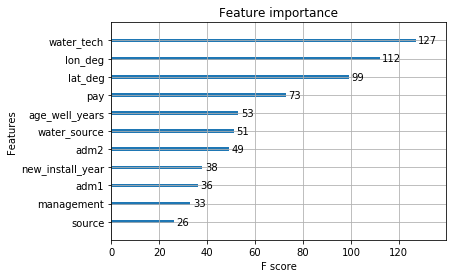

In [70]:
xgb.plot_importance(model_uganda)

model fit for  ['India']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.05}
0.974304523253
Accuracy : 0.9754
AUC Score (Test): 0.671043


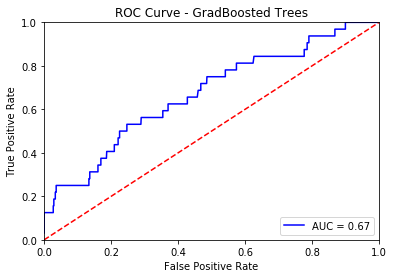

In [64]:
model_india, dict_india = predict_df(df_dict['India'])

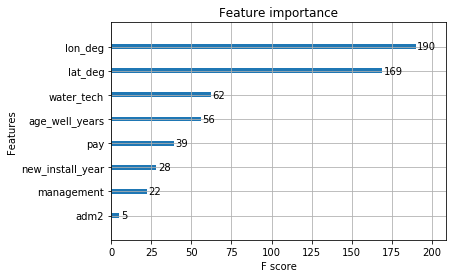

In [71]:
xgb.plot_importance(model_india)

model fit for  ['Swaziland']
{'max_depth': 4, 'n_estimators': 300, 'learning_rate': 0.1}
0.97498291901
Accuracy : 0.9748
AUC Score (Test): 0.995326


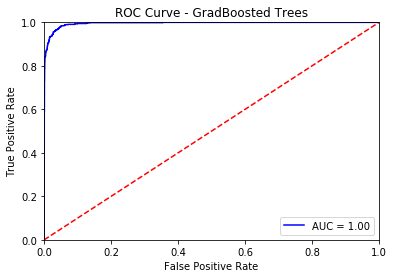

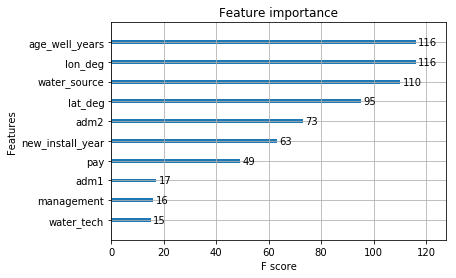

In [36]:
model, dict_swaz = predict_df(df_dict['Swaziland'])

In [72]:
#loop through all the countries
# DOESNT PRINT BOTH PICTURES. UPDATE TO SAVE ALL FIGURES AND SUBPLOTS LATER
# countries_for_preds = ['Afghanistan', 'Sierra Leone', 'Zimbabwe', 'Zimbabwe', 'Kenya', 'Liberia', 'Malawi', 'South Sudan', 
#           'Uganda','India']
# for k in countries_for_preds:
#     #k +'_model', k+'dict'  = predict_df(df_dict[k])
#     #predict_df(str(k)+'_df')
#     #print(df_dict[k].head()) #works
#     predict_df(df_dict[k]) # 

# To Do
    - Neatly show what is missing between which countries - Done
    - Grid search another classifier like random forests in addition to XGBoost.
    - Convert Uganda pay to currency using regex
    - use fuzzy wuzzy to organize water source and tech - sort of done
    - run country level models on each main country - DONE
    - Time since last measurement as new variable
    - clean function to fill in missing on certain values and then handline missing age_well differently - DONE
    - create a dict of label encodings so I can transform back!! SUPER IMPORTANT - DONE
    - Analyze rows that have multiple data points for time series work and remove
    - Globally, "None" is a value and isn't "Missing", need to merge all of thme (list below)
    -***Show AUC curve for Swaziland, Uganda**** -DONE
    -***Show Feature impact for Swaziland, Uganda***- DONE
    -****Show Partial Dependence Plots for Swaziland, Uganda*** - Have label encoding. Can now.
    -***Recalculate Uganda with Fuzzy Matched Columns****--DONE for tech, not source in Fuzzy notebook
    -*** use map func page 194 to replace all the weird nulls
    - create bins for age well in 5 year increments
    -map: water tech (India, Mark, mk,II--> India Mark2), (Bush Pump--> a,b,c- well labeled, keep), (Null, 0, None Other, no pump--> __Missing__), (Afridev has many associations), (gravity, gravity fed---> gravity), (brands--> Kabul, birka, india, afridev, nira), Stand, Tap, Bucket, 
    - map: water source (Dam river stream, borehole, dug well, tube well, shallowe well, well, 
    - addres missing values (multiple per) in Water Tech, Water Source, then do fuzzy match
    
    Contains ‘rain’ - 15,417
"""Contains ‘gravity’ - 17,022
Contains  ‘bore’ - 32,182
Contains ‘dug_well’ = 22,616
‘Shallow well’ = 17, 361
Tube well = 6368
Spring = 25,871
null/0ther = 60,000
Stand: 43, 531
Bucket: 27k
Tap: 6.7k """




    